In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import os
from datetime import datetime
import random
import gc
import pickle

In [25]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,IntegerType,StringType,DateType,FloatType,StructField,TimestampType
from pyspark.sql.functions import *
import pyspark_jobs

In [26]:
spark = SparkSession \
        .builder \
        .appName("Predict promo") \
        .config("spark.driver.memory", "2g") \
        .config("spark.executor.memory","4g") \
        .config("spark.ui.showConsoleProgress","True")\
        .getOrCreate()

In [27]:
schema = StructType([
   StructField("event_time", StringType(), True),
   StructField("event_type", StringType(), True),
   StructField("product_id", IntegerType(), True),
   StructField("category_id", StringType(), True),
   StructField("category_code", StringType(), True),
   StructField("brand", StringType(), True),
   StructField("price", FloatType(), True),
   StructField("user_id", IntegerType(), True),
   StructField("user_session", StringType(), True)])

In [28]:
df = spark.read.format('csv').load('Data/2019-Oct.csv',header=True,schema=schema)

In [29]:
train,test = df.randomSplit([0.7,0.3],45)

In [30]:
train = train.na.drop()
test = test.na.drop()

In [31]:
train.show(5)
test.show(5)

+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|          event_time|event_type|product_id|        category_id|       category_code|   brand|  price|  user_id|        user_session|
+--------------------+----------+----------+-------------------+--------------------+--------+-------+---------+--------------------+
|2019-10-01 00:00:...|      view|   1004237|2053013555631882655|electronics.smart...|   apple|1081.98|535871217|c6bd7419-2748-4c5...|
|2019-10-01 00:00:...|      view|   1480613|2053013561092866779|   computers.desktop|  pulser| 908.62|512742880|0d0d91c2-c9c2-4e8...|
|2019-10-01 00:00:...|      view|   1004545|2053013555631882655|electronics.smart...|  huawei| 566.01|537918940|406c46ed-90a4-478...|
|2019-10-01 00:00:...|      view|   1005011|2053013555631882655|electronics.smart...| samsung| 900.64|530282093|50a293fb-5940-41b...|
|2019-10-01 00:00:...|      view|   2900536|205301355477624459

In [34]:
from pyspark.sql import Window
from itertools import chain
from pyspark.ml.feature import StringIndexer
import pyspark_jobs
from pyspark.ml.feature import StandardScaler,VectorAssembler

def transform_data(df):
    df = df.withColumn('event_time',df.event_time.substr(1,19).cast(TimestampType()))
    df = df.withColumn('hour',hour(df.event_time))\
        .withColumn('day_of_week',dayofweek(df.event_time))\
        .withColumn('day_of_month',dayofmonth(df.event_time))\
        .withColumn('month',month(df.event_time))\
        .withColumn('year',year(df.event_time))\
        .withColumn('category',split(df.category_code,"\.").getItem(0))\
        .withColumn('subcategory',split(df.category_code,"\.").getItem(1))
    df = df.drop('category_code')
    cnt = df.groupBy(['user_session','user_id']).count().select('user_session','user_id', col('count').alias('activity_count'))
    df = df.join(cnt, ['user_session','user_id'])
    
    window = Window.partitionBy('user_session','user_id').orderBy('event_time')
    df = df.withColumn('prev_activity',lag('activity_count',1).over(window))
    
    d = {'purchase':1,'view':0,'cart':0}
    mapping = create_map([lit(x) for x in chain(*d.items())])
    df = df.withColumn('is_purchased',coalesce(mapping[df['event_type']],df['event_type']).alias('is_purchased'))
    
    df = df.withColumn('prev_purchase',lag('is_purchased',1).over(window))

    indexer = StringIndexer(inputCols=['brand','category','subcategory'],outputCols=['brand_tr','category_tr','subcategory_tr']).fit(df)
    
    indexed = indexer.transform(df)
    
    schema = {'prev_activity':'int','prev_purchase':'int','is_purchased':'int'}
    indexed = pyspark_jobs.change_col_type(indexed,schema)
    
    indexed = indexed.drop('event_type','brand','category','subcategory')
    indexed = indexed.fillna(0)

    cols = ['price','hour','day_of_week','day_of_month','month','year','activity_count','brand_tr','category_tr','subcategory_tr','prev_activity','prev_purchase']
    assembler = VectorAssembler().setInputCols(cols).setOutputCol('features')
    transformed = assembler.transform(indexed)

    scaler = StandardScaler(inputCol='features',outputCol='scaledFeatures')
    model  = scaler.fit(transformed.select('features'))
    scaled_features = model.transform(transformed)
      
    
    scaled_features = scaled_features.drop('features')
    model.save('PickledObjects/scaler_v0.3')    
    assembler.save('PickledObjects/assembler_v0.3')  
    indexer.save('PickledObjects/indexer_v0.3')
    return scaled_features

In [35]:
transformed_train = transform_data(train)

In [36]:
transformed_train.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+-------------+--------+-----------+--------------+--------------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchase|brand_tr|category_tr|subcategory_tr|      scaledFeatures|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+-------------+--------+-----------+--------------+--------------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:27:02|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             2|            0|           1|            0|   186.0|        1.0|          20.0|[2.04809407735095...|
|0003726c-81ad-49c..

In [37]:
from pyspark.ml.classification import LogisticRegression

model = LogisticRegression(featuresCol='scaledFeatures', labelCol='is_purchased', predictionCol='prediction',\
                           maxIter=500, regParam=0.001, elasticNetParam=0.0, tol=1e-06, fitIntercept=True,\
                           threshold=0.5,aggregationDepth=2, family='auto').fit(transformed_train)


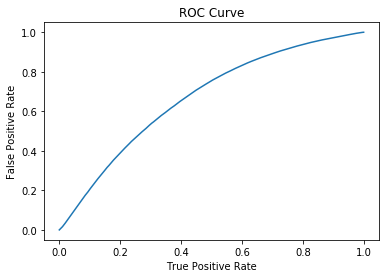

Training set ROC: 0.6684086773799041


In [38]:
import matplotlib.pyplot as plt

trainingSummary = model.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set ROC: ' + str(trainingSummary.areaUnderROC))

In [39]:
trainingSummary.accuracy

0.9793295783213756

In [24]:
transformed_train.groupBy('is_purchased').count().show()

+------------+--------+
|is_purchased|   count|
+------------+--------+
|           1|  384331|
|           0|18208952|
+------------+--------+



In [40]:
from pyspark.sql import Window
from itertools import chain
from pyspark.ml.feature import StringIndexerModel
import pyspark_jobs
from pyspark.ml.feature import StandardScalerModel,VectorAssembler

def transform_data_model(df):
    df = df.withColumn('event_time',df.event_time.substr(1,19).cast(TimestampType()))
    df = df.withColumn('hour',hour(df.event_time))\
        .withColumn('day_of_week',dayofweek(df.event_time))\
        .withColumn('day_of_month',dayofmonth(df.event_time))\
        .withColumn('month',month(df.event_time))\
        .withColumn('year',year(df.event_time))\
        .withColumn('category',split(df.category_code,"\.").getItem(0))\
        .withColumn('subcategory',split(df.category_code,"\.").getItem(1))
    df = df.drop('category_code')
    cnt = df.groupBy(['user_session','user_id']).count().select('user_session','user_id', col('count').alias('activity_count'))
    df = df.join(cnt, ['user_session','user_id'])
    
    window = Window.partitionBy('user_session','user_id').orderBy('event_time')
    df = df.withColumn('prev_activity',lag('activity_count',1).over(window))
    
    d = {'purchase':1,'view':0,'cart':0}
    mapping = create_map([lit(x) for x in chain(*d.items())])
    df = df.withColumn('is_purchased',coalesce(mapping[df['event_type']],df['event_type']).alias('is_purchased'))
    
    df = df.withColumn('prev_purchase',lag('is_purchased',1).over(window))

    indexer = StringIndexerModel.load('PickledObjects/indexer_v0.3').setHandleInvalid("keep")
    
    indexed = indexer.transform(df)
    
    schema = {'prev_activity':'int','prev_purchase':'int','is_purchased':'int'}
    indexed = pyspark_jobs.change_col_type(indexed,schema)
    
    indexed = indexed.drop('event_type','brand','category','subcategory')
    indexed = indexed.fillna(0)

    cols = ['price','hour','day_of_week','day_of_month','month','year','activity_count','brand_tr','category_tr','subcategory_tr','prev_activity','prev_purchase']
    assembler = VectorAssembler.load('PickledObjects/assembler_v0.3')
    transformed = assembler.transform(indexed)

    scaler = StandardScalerModel.load('PickledObjects/scaler_v0.3')
    scaled_features = scaler.transform(transformed)
      
    
    scaled_features = scaled_features.drop('features')
#     model.save('PickledObjects/scaler_v0.3')    
#     assembler.save('PickledObjects/assembler_v0.3')  
#     indexer.save('PickledObjects/indexer_v0.3')
    return scaled_features

In [41]:
transformed_test = transform_data_model(test)

In [42]:
transformed_test.show(5)

+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+-------------+--------+-----------+--------------+--------------------+
|        user_session|  user_id|         event_time|product_id|        category_id| price|hour|day_of_week|day_of_month|month|year|activity_count|prev_activity|is_purchased|prev_purchase|brand_tr|category_tr|subcategory_tr|      scaledFeatures|
+--------------------+---------+-------------------+----------+-------------------+------+----+-----------+------------+-----+----+--------------+-------------+------------+-------------+--------+-----------+--------------+--------------------+
|0003726c-81ad-49c...|515826621|2019-10-26 13:26:06|   5000556|2053013566100866035|780.53|  13|          7|          26|   10|2019|             1|            0|           0|            0|   186.0|        1.0|          20.0|[2.04809407735095...|
|000729f8-7f6c-43f..

In [43]:
pred = model.transform(transformed_test)

In [44]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='is_purchased')
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(pred, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.6572401566343665


In [45]:
trainingSummary.fMeasureByLabel()

[0.9895568570767509, 0.0]

In [46]:
trainingSummary.precisionByLabel

[0.9793295783213756, 0.0]

In [62]:
from pyspark.ml.classification import GBTClassifier

model = GBTClassifier(featuresCol='scaledFeatures', labelCol='is_purchased',\
                      predictionCol='prediction', maxDepth=8, maxBins=32, \
                      minInstancesPerNode=1, minInfoGain=0.1, maxMemoryInMB=256,\
                      cacheNodeIds=False, checkpointInterval=10, lossType="logistic",\
                      maxIter=10, stepSize=0.1).fit(transformed_train)


In [64]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Make predictions.
predictions = model.transform(transformed_train)


from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='is_purchased')
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test_SET (Area Under ROC): 0.5


In [66]:
from pyspark.ml.classification import LinearSVC

model = LinearSVC(featuresCol='scaledFeatures', labelCol='is_purchased').fit(transformed_train)

KeyboardInterrupt: 

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictions = model.transform(transformed_train)

evaluator = BinaryClassificationEvaluator(labelCol='is_purchased')
print("Test_SET (Area Under ROC): " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

In [67]:
spark.stop()